In [51]:
import pandas as pd
from skimage.io import imread
from skimage import io, data
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from skimage.transform import resize
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Softmax
from torch.optim import Adam, SGD

In [2]:
trainData = pd.read_csv('problem2-CNN/train.csv')
testData = pd.read_csv('problem2-CNN/test.csv')

In [3]:
trainData

,filename,width,height,label,xmin,ymin,xmax,ymax
0,11893820-3x2-xlarge.jpg,862,575,bad,12,238,92,318
1,11893820-3x2-xlarge.jpg,862,575,bad,46,42,104,97
2,11893820-3x2-xlarge.jpg,862,575,good,103,24,150,79
3,11893820-3x2-xlarge.jpg,862,575,good,243,2,291,51
4,11893820-3x2-xlarge.jpg,862,575,bad,166,36,228,99
...,...,...,...,...,...,...,...,...
3523,kljlhk.jpg,1548,1032,good,1481,239,1546,353
3524,kljlhk.jpg,1548,1032,good,328,273,361,312
3525,kljlhk.jpg,1548,1032,good,283,245,318,289
3526,kljlhk.jpg,1548,1032,good,226,251,257,289


In [4]:
img_num = trainData['filename']
img_num_test = testData['filename']
Y_train_data = trainData['label']
Y_test_data = testData['label']

In [5]:
# image_path = 'problem2-CNN/images/' + str(filename_1)
# img = imread(image_path)
# plt.imshow(img)

In [6]:
train_data = []

for i in tqdm(range(len(img_num))):
    filename = trainData['filename'][i]
    image_path = 'problem2-CNN/images/' + str(filename)
    img = imread(image_path)
    if img.shape[-1] > 3:
        # discard alpha channel
        img = img[:, :, :3]
    xmin = trainData['xmin'][i]
    xmax = trainData['xmax'][i]
    ymin = trainData['ymin'][i]
    ymax = trainData['ymax'][i]
    #   切割與resize
    partial_img_temp = img[ymin:ymax, xmin:xmax, :]
    partial_img = resize(partial_img_temp, (64, 64))
    
    partial_img = np.reshape(partial_img, (1, 3, 64, 64))
    #   貌似normalize過惹 
    
    
    
        #解決data unbalabce
    if Y_train_data[i] == "bad":
        for i in range(4):
            train_data.append(partial_img)
    elif Y_train_data[i] == "none":
        for i in range(20):
            train_data.append(partial_img)
        #解決data unbalabce
    else:
        train_data.append(partial_img)
#     io.imshow(partial_img)
#     io.show()

100%|██████████| 3528/3528 [01:45<00:00, 33.29it/s]


In [7]:
test_data = []

for i in tqdm(range(len(img_num_test))):
    filename = testData['filename'][i]
    image_path = 'problem2-CNN/images/' + str(filename)
    img = imread(image_path)
    if img.shape[-1] > 3:
        # discard alpha channel
        img = img[:, :, :3]
    xmin = testData['xmin'][i]
    xmax = testData['xmax'][i]
    ymin = testData['ymin'][i]
    ymax = testData['ymax'][i]
    #   切割與resize
    partial_img_temp = img[ymin:ymax, xmin:xmax, :]
    partial_img = resize(partial_img_temp, (64, 64))
    partial_img = np.reshape(partial_img, (1, 3, 64, 64))
    #   貌似normalize過惹 
    test_data.append(partial_img)

100%|██████████| 394/394 [00:10<00:00, 38.81it/s]


TypeError: Invalid shape (3, 64, 64) for image data

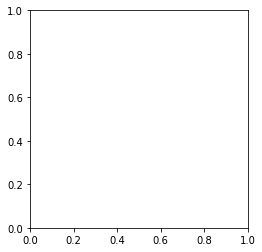

In [97]:
# plt.imshow(train_data[0])

In [9]:
print(train_data[0].shape)

(1, 3, 64, 64)


In [10]:
#train_data_temp = resize(train_data[0], (64, 64))

In [11]:
#plt.imshow(train_data_temp)

In [12]:
#np.max(train_data_temp)

In [13]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

# N, D_in, H, D_out = 64, 1000, 100, 3
#D_in, H, D_out = 4 * 16 * 16, 100, 3


In [14]:
def evaluation(predicts, golds):
    correct = 0
    total = len(predicts)
    for predict, gold in zip(predicts, golds):
        if predict == gold:
            correct += 1
    return correct / total

In [92]:
 class Net(nn.Module):
        def __init__(self, D_in = 4 * 16 * 16, H = 100, D_out = 3):
            super(Net, self).__init__()
            self.CNN = nn.Sequential(
                    # Defining a 2D convolution layer
                Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
                BatchNorm2d(4),
                ReLU(inplace=True),
                MaxPool2d(kernel_size=2, stride=2),
                    # Defining another 2D convolution layer
                Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
                BatchNorm2d(4),
                ReLU(inplace=True),
                MaxPool2d(kernel_size=2, stride=2),

            )
            self.DNN = nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Linear(H, D_out),
                
            )
#             self.softmax = nn.Softmax
            
        def forward(self, x):
            x = self.CNN(x)
            x = x.view(x.shape[0], -1)
            x = self.DNN(x)
#             x = self.softmax(x)
            return x

In [130]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
model = Net()
optimizer = Adam(model.parameters(), lr=0.0007)

In [17]:
#test

# train_data_temp = np.reshape(train_data_temp, (1, 3, 64, 64))
# testtest = torch.from_numpy(train_data_temp).float()
# #print(testtest)
# #testtest = Variable(testtest)
# #print(testtest)

# y_pred = CNN(testtest)
# y_pred = y_pred.view(train_data_temp.shape[0], -1)
# y_out = DNN(y_pred)
# #loss = loss_func(y_out)



In [18]:
Y_train_data = trainData['label']
Y_train_data_list = []
for i in range(len(Y_train_data)):
    if Y_train_data[i] == "good":
        Y_train_data_list.append(np.array([0]))
    elif Y_train_data[i] == "bad":
        for i in range(4):
            Y_train_data_list.append(np.array([1]))
    else:
        for i in range(20):
            Y_train_data_list.append(np.array([2]))
Y_train = np.vstack(Y_train_data_list)
        

In [19]:
Y_train.shape

(7238, 1)

In [20]:
Y_train = np.reshape(Y_train, (-1))


NameError: name 'Y_test' is not defined

In [21]:
Y_train.shape

(7238,)

In [22]:
Y_test_data = testData['label']
Y_test_data_list = []
for i in range(len(Y_test_data)):
    if Y_test_data[i] == "good":
        Y_test_data_list.append(np.array([0]))
    elif Y_test_data[i] == "bad":
        Y_test_data_list.append(np.array([1]))
    else:
        Y_test_data_list.append(np.array([2]))
Y_test = np.vstack(Y_test_data_list)

In [23]:
Y_test = np.reshape(Y_test, (-1))

In [24]:
Y_test.shape

(394,)

In [25]:
#因為用append所以是很多np.array, 所以用vstack改成單一np.array
train_data = np.vstack(train_data)
test_data = np.vstack(test_data)

In [26]:
print(train_data.shape)

(7238, 3, 64, 64)


In [131]:
def train_epoch(model, train_data, Y_train, test_data, Y_test, batch_size = 64, epoch = 10):
    model.train()
    test_data = torch.from_numpy(test_data).float()
    Y_test = torch.from_numpy(Y_test)
    for i in range(epoch):
        permutation = np.random.permutation(train_data.shape[0])
        train_data_shuffled = train_data[permutation, :, :, :]
        Y_train_shuffled = Y_train[permutation]
        epoch_loss = 0
        batch_num = len(train_data) // batch_size
        predicts = []
        predicts_test = []
        golds = []
        
        for j in range(batch_num):
            model.train(mode=True)
            begin = j * batch_size
            end = min(begin + batch_size, train_data.shape[0] - 1)
            X = train_data_shuffled[begin:end, :, :, :]
#             print(X[0])
            Y = Y_train_shuffled[begin:end]
            m_batch = end - begin
            
            # converting validation images into torch format
            X = torch.from_numpy(X).float()
            Y = torch.from_numpy(Y)
            
            
            
            #X_afterCNN = CNN(X)
            #X_afterCNN = X_afterCNN.view(X.shape[0], -1)
            #X_afterDNN = DNN(X_afterCNN)
            
            X_afterDNN = model(X)
            y_hat = torch.softmax(X_afterDNN, dim=1)
            
            #------test data-------------
            model.eval()
            
            test_result_temp = model(test_data)
            test_result = torch.softmax(test_result_temp, dim=1)
            #print(X_afterDNN)
            #print(Y)
            
            loss = loss_func(y_hat, Y)
            epoch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             print(y_hat)
#             print(test_result)


            golds += Y.tolist()
            
            predicts += torch.argmax(y_hat, dim=1).tolist()
#         print("predict : ", predicts)
        predicts_test += torch.argmax(test_result, dim=1).tolist()
#         print("gold : ", golds)
#         print(predicts)
#         print(Y_train)
#         golds += np.argmax(Y_train, axis=).tolist()
        print("epoch : ", i + 1, "loss : ", epoch_loss / train_data.shape[0], "train_accur : "
              , evaluation(predicts, golds), "test_accur : ", evaluation(predicts_test, Y_test))

In [132]:
train_epoch(model, train_data, Y_train, test_data, Y_test, batch_size = 64, epoch = 50)

epoch :  1 loss :  0.8501696232176182 train_accur :  0.7013274336283186 test_accur :  0.799492385786802
epoch :  2 loss :  0.7178597657118557 train_accur :  0.8390486725663717 test_accur :  0.8756345177664975
epoch :  3 loss :  0.6799972546828587 train_accur :  0.8770741150442478 test_accur :  0.8984771573604061
epoch :  4 loss :  0.6601753271755905 train_accur :  0.8957411504424779 test_accur :  0.8959390862944162
epoch :  5 loss :  0.650713105529802 train_accur :  0.9034845132743363 test_accur :  0.8781725888324873
epoch :  6 loss :  0.6403774415369553 train_accur :  0.9131637168141593 test_accur :  0.8959390862944162
epoch :  7 loss :  0.6377562902091649 train_accur :  0.9153761061946902 test_accur :  0.8883248730964467
epoch :  8 loss :  0.6339164211065541 train_accur :  0.9196626106194691 test_accur :  0.9137055837563451
epoch :  9 loss :  0.6320687262647617 train_accur :  0.9196626106194691 test_accur :  0.9187817258883249
epoch :  10 loss :  0.6256762660317211 train_accur :  0.9

In [ ]:
np.unique(Y_train)

In [ ]:
train_data[953].shape

In [ ]:
plt.imshow(train_data[953])

In [ ]:
np.random.permutation(10)

In [ ]:
a = [1, 2, 3, 4]
np.random.shuffle(a)
a

In [50]:

for i in range(3):
    print("yo")



yo
yo
yo


In [40]:
a = np.array([[2,4,6,1],[1,5,2,9]])
a


array([[2, 4, 6, 1],
       [1, 5, 2, 9]])

In [41]:
np.argmax(a, axis=1)

array([2, 3])

In [42]:
b = torch.from_numpy(a).float()
b

tensor([[2., 4., 6., 1.],
        [1., 5., 2., 9.]])

In [43]:
torch.argmax(b, dim=1)

tensor([2, 3])